<!-- Copyright (c) 2021-2024, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# Knowledge Distillation Applied to LIC

In [1]:
import time
import io
import math
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_msssim import ms_ssim

from compressai.zoo.image import (
    model_urls,
    load_state_dict_from_url,
    load_pretrained,
    _load_model,
    bmshj2018_hyperprior,
    mbt2018_mean,
    mbt2018
)

from fvcore.nn import FlopCountAnalysis
from zeus.monitor import ZeusMonitor
from zeus.device.cpu import get_current_cpu_index

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from models import ScaleHyperprior, MeanScaleHyperprior, JointAutoregressiveHierarchicalPriors

/home/ids/fallemand-24/anaconda3/envs/prim_env/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)


def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()


def compute_bpp(out_net):
    size = out_net["x_hat"].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
               for likelihoods in out_net["likelihoods"].values()).item()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Load Models

In [4]:
N_teacher = 128
M = 192

In [5]:
# Teacher Model
url = model_urls["bmshj2018-hyperprior"]["mse"][5]
state_dict = load_state_dict_from_url(url, progress=False)
state_dict = load_pretrained(state_dict)
teacher = ScaleHyperprior.from_state_dict(state_dict).eval().to(device)

In [6]:
# Student Model
# id = 258263 # 16
# id = 259782 # 16
id = 263674 # 16
student_16 = ScaleHyperprior(16, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_16.load_state_dict(checkpoint["state_dict"])
student_16 = student_16.eval().to(device)

In [8]:
# Student Model
# id = 258258 # 32
# id = 259783 # 32
id = 263687 # 32
student_32 = ScaleHyperprior(32, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_32.load_state_dict(checkpoint["state_dict"])
student_32 = student_32.eval().to(device)

RuntimeError: Error(s) in loading state_dict for ScaleHyperprior:
	size mismatch for entropy_bottleneck._matrix0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._bias0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._factor0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._matrix1: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3]).
	size mismatch for entropy_bottleneck._bias1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._factor1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._matrix2: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3]).
	size mismatch for entropy_bottleneck._bias2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._factor2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._matrix3: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3]).
	size mismatch for entropy_bottleneck._bias3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._factor3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1]).
	size mismatch for entropy_bottleneck._matrix4: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3]).
	size mismatch for entropy_bottleneck._bias4: copying a param with shape torch.Size([112, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for entropy_bottleneck.quantiles: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3]).
	size mismatch for g_a.0.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 3, 5, 5]).
	size mismatch for g_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for g_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for g_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_a.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_a.6.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 32, 5, 5]).
	size mismatch for g_s.0.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 32, 5, 5]).
	size mismatch for g_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for g_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_s.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for g_s.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for g_s.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for g_s.6.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 3, 5, 5]).
	size mismatch for h_a.0.weight: copying a param with shape torch.Size([112, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 192, 3, 3]).
	size mismatch for h_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for h_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for h_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for h_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for h_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for h_s.0.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for h_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for h_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for h_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for h_s.4.weight: copying a param with shape torch.Size([192, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 32, 3, 3]).

In [9]:
# Student Model
# id = 258259 # 64
# id = 259784 # 64
id = 263688 # 64
student_64 = ScaleHyperprior(64, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_64.load_state_dict(checkpoint["state_dict"])
student_64 = student_64.eval().to(device)

RuntimeError: Error(s) in loading state_dict for ScaleHyperprior:
	size mismatch for entropy_bottleneck._matrix0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._bias0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._factor0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._matrix1: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3]).
	size mismatch for entropy_bottleneck._bias1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._factor1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._matrix2: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3]).
	size mismatch for entropy_bottleneck._bias2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._factor2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._matrix3: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3]).
	size mismatch for entropy_bottleneck._bias3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._factor3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([64, 3, 1]).
	size mismatch for entropy_bottleneck._matrix4: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([64, 1, 3]).
	size mismatch for entropy_bottleneck._bias4: copying a param with shape torch.Size([112, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1, 1]).
	size mismatch for entropy_bottleneck.quantiles: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([64, 1, 3]).
	size mismatch for g_a.0.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 3, 5, 5]).
	size mismatch for g_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for g_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for g_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_a.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_a.6.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 64, 5, 5]).
	size mismatch for g_s.0.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 64, 5, 5]).
	size mismatch for g_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for g_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_s.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for g_s.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for g_s.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for g_s.6.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 3, 5, 5]).
	size mismatch for h_a.0.weight: copying a param with shape torch.Size([112, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 192, 3, 3]).
	size mismatch for h_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for h_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for h_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for h_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for h_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for h_s.0.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for h_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for h_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for h_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for h_s.4.weight: copying a param with shape torch.Size([192, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 64, 3, 3]).

In [10]:
# Student Model
# id = 258262 # 96
# id = 259785 # 96
id = 263690 # 96
student_96 = ScaleHyperprior(96, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_96.load_state_dict(checkpoint["state_dict"])
student_96 = student_96.eval().to(device)

RuntimeError: Error(s) in loading state_dict for ScaleHyperprior:
	size mismatch for entropy_bottleneck._matrix0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._bias0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._factor0: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._matrix1: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 3, 3]).
	size mismatch for entropy_bottleneck._bias1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._factor1: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._matrix2: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 3, 3]).
	size mismatch for entropy_bottleneck._bias2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._factor2: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._matrix3: copying a param with shape torch.Size([112, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 3, 3]).
	size mismatch for entropy_bottleneck._bias3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._factor3: copying a param with shape torch.Size([112, 3, 1]) from checkpoint, the shape in current model is torch.Size([96, 3, 1]).
	size mismatch for entropy_bottleneck._matrix4: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([96, 1, 3]).
	size mismatch for entropy_bottleneck._bias4: copying a param with shape torch.Size([112, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 1, 1]).
	size mismatch for entropy_bottleneck.quantiles: copying a param with shape torch.Size([112, 1, 3]) from checkpoint, the shape in current model is torch.Size([96, 1, 3]).
	size mismatch for g_a.0.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 3, 5, 5]).
	size mismatch for g_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for g_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for g_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_a.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_a.6.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 96, 5, 5]).
	size mismatch for g_s.0.weight: copying a param with shape torch.Size([192, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 96, 5, 5]).
	size mismatch for g_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.1.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.1.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for g_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.3.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.3.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_s.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for g_s.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.5.beta: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for g_s.5.gamma: copying a param with shape torch.Size([112, 112]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for g_s.6.weight: copying a param with shape torch.Size([112, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 3, 5, 5]).
	size mismatch for h_a.0.weight: copying a param with shape torch.Size([112, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 192, 3, 3]).
	size mismatch for h_a.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for h_a.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for h_a.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for h_a.4.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for h_a.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for h_s.0.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for h_s.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for h_s.2.weight: copying a param with shape torch.Size([112, 112, 5, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 5, 5]).
	size mismatch for h_s.2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for h_s.4.weight: copying a param with shape torch.Size([192, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 96, 3, 3]).

In [11]:
# Student Model
# id = 259786 # 112
id = 263691 # 112
student_112 = ScaleHyperprior(112, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_112.load_state_dict(checkpoint["state_dict"])
student_112 = student_112.eval().to(device)

In [11]:
# Student Model
id = 261095 # 112 KL
student_112_kl = ScaleHyperprior(112, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_112_kl.load_state_dict(checkpoint["state_dict"])
student_112_kl = student_112_kl.eval().to(device)

In [12]:
models = {
    "teacher": {"model": teacher, "metrics": {"params": sum(p.numel() for p in teacher.parameters())}},
    "student_16": {"model": student_16, "metrics": {"params": sum(p.numel() for p in student_16.parameters())}},
    # "student_32": {"model": student_32, "metrics": {"params": sum(p.numel() for p in student_32.parameters())}},
    # "student_64": {"model": student_64, "metrics": {"params": sum(p.numel() for p in student_64.parameters())}},
    # "student_96": {"model": student_96, "metrics": {"params": sum(p.numel() for p in student_96.parameters())}},
    "student_112": {"model": student_112, "metrics": {"params": sum(p.numel() for p in student_112.parameters())}},
    # "student_112_kl": {"model": student_112_kl, "metrics": {"params": sum(p.numel() for p in student_112_kl.parameters())}},
}

## Models Comparison

### Saint Malo

In [13]:
test_transforms = transforms.Compose(
    [transforms.RandomCrop((256,256)), transforms.ToTensor()]
)

img = Image.open("../data/assets/stmalo_fracape.png").convert("RGB")
x = test_transforms(img).unsqueeze(0).to(device)
print(x.shape)

torch.Size([1, 3, 256, 256])


In [14]:
# Flops computation
with torch.no_grad():
    for model in models.keys():
        flops = FlopCountAnalysis(models[model]["model"], x)
        models[model]["metrics"]["flops"] = flops.total()

Unsupported operator prim::PythonOp.LowerBoundFunction encountered 15 time(s)
Unsupported operator aten::pow encountered 18 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::rsqrt encountered 3 time(s)
Unsupported operator aten::mul encountered 18 time(s)
Unsupported operator aten::abs encountered 2 time(s)
Unsupported operator aten::clone encountered 2 time(s)
Unsupported operator aten::sub_ encountered 1 time(s)
Unsupported operator aten::round encountered 2 time(s)
Unsupported operator aten::add_ encountered 19 time(s)
Unsupported operator aten::softplus encountered 10 time(s)
Unsupported operator aten::tanh encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)
Unsupported operator aten::sigmoid encountered 2 time(s)
Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::erfc encountered 2 time(s)
Unsupported operator aten::sqrt encountered 3 ti

In [ ]:
%%script false --no-raise-error
# Energy consumption computation
current_cpu_index = get_current_cpu_index()
monitor = ZeusMonitor(cpu_indices=[current_cpu_index], gpu_indices=[])
with torch.no_grad():
    for model in models.keys():
        monitor.begin_window("step")
        output = models[model]["model"].forward(x)
        monitor.end_window("step")

In [16]:
# Inference
criterion = nn.MSELoss()
with torch.no_grad():
    for model in models.keys():
        start = time.time()
        output = models[model]["model"].forward(x)
        stop = time.time()

        models[model]["metrics"]["inference time"] = stop - start
        models[model]["metrics"]["mse"] = criterion(output["x_hat"], x).item()
        models[model]["metrics"]["psnr"] = compute_psnr(output["x_hat"], x)
        models[model]["metrics"]["ms_ssim"] = compute_msssim(output["x_hat"], x)
        models[model]["metrics"]["bpp"] = compute_bpp(output)

        models[model]["output"] = output

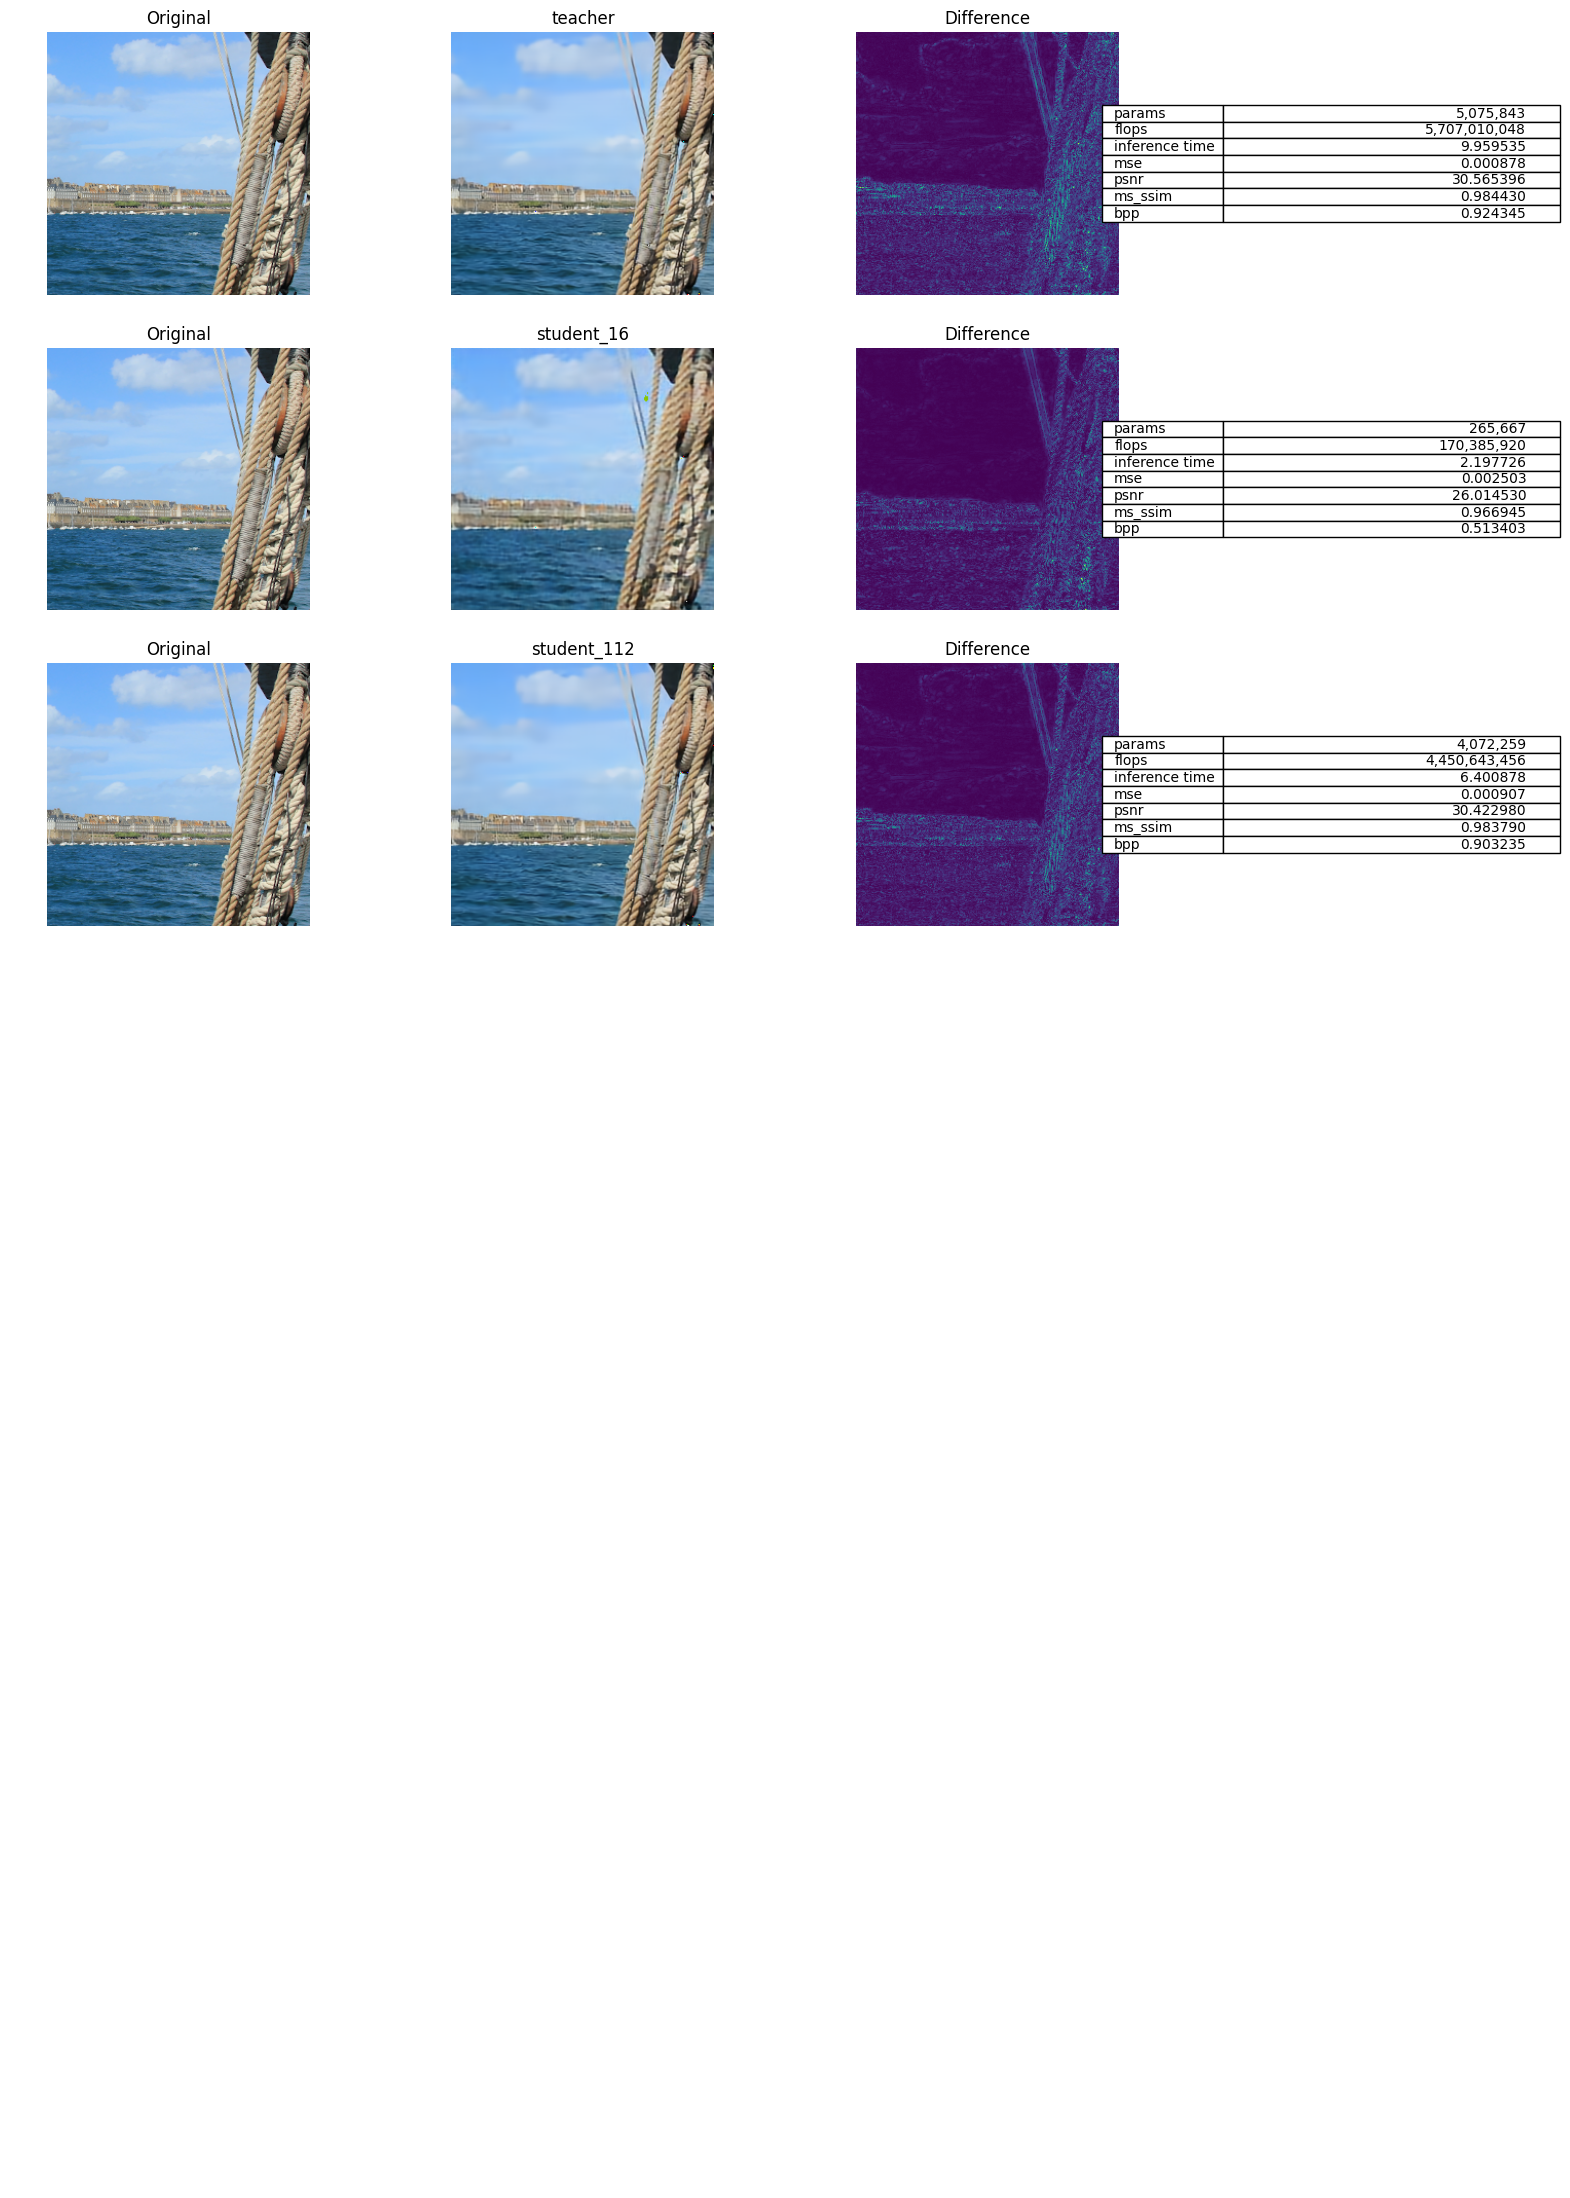

In [17]:
n_rows = 7
fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows))

orig = transforms.ToPILImage()(x.squeeze().cpu())

for ax in axs.ravel():
    ax.axis("off")

for i, model in enumerate(models.keys()):
    axs[i, 0].imshow(orig)
    axs[i, 0].title.set_text("Original")

    recons = transforms.ToPILImage()(models[model]["output"]["x_hat"].squeeze().cpu())
    axs[i, 1].imshow(recons)
    axs[i, 1].title.set_text(model)

    diffs = torch.mean((models[model]["output"]["x_hat"] - x).abs(), axis=1).squeeze().cpu()
    axs[i, 2].imshow(diffs, cmap="viridis")
    axs[i, 2].title.set_text(f"Difference")

    axs[i, 3].set_axis_off()
    axs[i, 3].table(rowLabels=list(models[model]["metrics"].keys()),
                    cellText=[[f"{m:,}"] if isinstance(m, int) else [f"{m:.6f}"] for m in models[model]["metrics"].values()],
                    loc="center")

plt.show()